In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
column_names = []

with open("data\\breast-cancer.labels") as f:
    for line in f.readlines():
        column_names.append(line[:(len(line))-1])

In [3]:
breast_cancer_train = pd.io.parsers.read_csv("data\\breast-cancer-train.dat")
breast_cancer_train.columns = column_names

breast_cancer_validate =  pd.io.parsers.read_csv("data\\breast-cancer-validate.dat")
breast_cancer_validate.columns = column_names

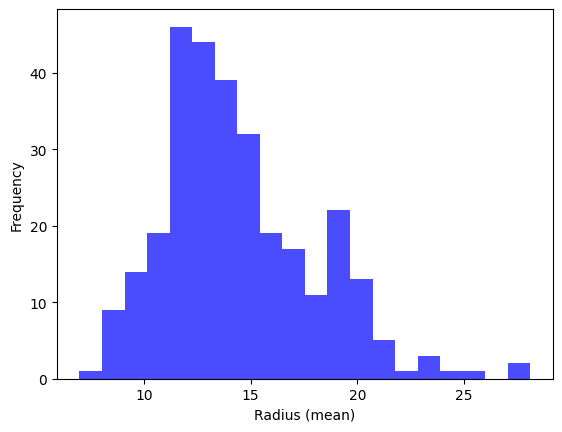

In [4]:
plt.hist(breast_cancer_train["radius (mean)"],bins=20, color='blue', alpha=0.7)
plt.ylabel("Frequency")
plt.xlabel("Radius (mean)")
plt.show()

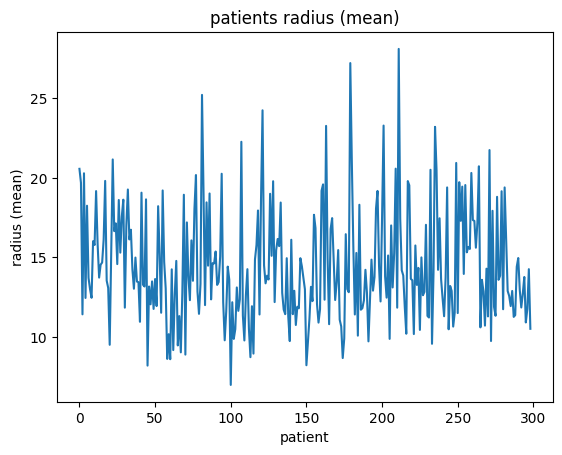

In [5]:
plt.plot(breast_cancer_train["radius (mean)"])
plt.title("patients radius (mean)")
plt.xlabel("patient")
plt.ylabel("radius (mean)")
plt.show()

In [6]:
# breast_cancer_train_linear_matrix = np.matrix(breast_cancer_train)
# breast_cancer_validate_linear_matrix = np.matrix(breast_cancer_validate)

# Train
# Liniowa
A_lin_train = breast_cancer_train.drop("Malignant/Benign", axis=1).values
A_lin_train = np.column_stack((np.ones(A_lin_train.shape[0]), A_lin_train))
# Kwadratowa
A_quad_train = breast_cancer_train[["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]].values
A_quad_train = np.column_stack((np.ones(A_quad_train.shape[0]), A_quad_train, A_quad_train**2))

# Validate
# Liniowa
A_lin_validate = breast_cancer_validate.drop("Malignant/Benign", axis=1).values
A_lin_validate = np.column_stack((np.ones(A_lin_validate.shape[0]), A_lin_validate))
# Kwadratowa
A_quad_validate = breast_cancer_validate[["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]].values
A_quad_validate = np.column_stack((np.ones(A_quad_validate.shape[0]), A_quad_validate, A_quad_validate**2))


# breast_cancer_train_square_matrix = np.zeros([299,16])
# breast_cancer_validate_square_matrix = np.zeros([299,16])

In [7]:
b_train = np.where(breast_cancer_train['Malignant/Benign'] == 'M', 1, -1)
b_validate = np.where(breast_cancer_validate['Malignant/Benign'] == 'M', 1, -1)

In [8]:
# Liniowa
w_lin = np.linalg.solve(A_lin_train.T @ A_lin_train, A_lin_train.T @ b_train)
# Kwadratowa
w_quad = np.linalg.solve(A_quad_train.T @ A_quad_train, A_quad_train.T @ b_train)

In [9]:
cond_lin = (np.linalg.cond(A_lin_train))**2
cond_quad = (np.linalg.cond(A_quad_train))**2

In [10]:
# Liniowa
p_lin = A_lin_train @ w_lin
p_lin = np.where(p_lin > 0, 1, -1)

# Kwadratowa
p_quad = A_quad_train @ w_quad
p_quad = np.where(p_quad > 0, 1, -1)


In [11]:
# # Liniowa
false_positives_lin = np.sum(np.logical_and(p_lin > 0, b_train < 0))
false_negatives_lin = np.sum(np.logical_and(p_lin < 0, b_train > 0))

# Kwadratowa
false_positives_quad = np.sum(np.logical_and(p_quad > 0, b_train < 0))
false_negatives_quad = np.sum(np.logical_and(p_quad < 0, b_train > 0))

print("Liniowa")
print("False positives:", false_positives_lin)
print("False negatives:", false_negatives_lin)
print("Kwadratowa")
print("False positives:", false_positives_quad)
print("False negatives:", false_negatives_quad)

Liniowa
False positives: 2
False negatives: 10
Kwadratowa
False positives: 11
False negatives: 17
